# Stanford Dogs Dataset Classifier

Training a NN to classify the Stanford Dogs Dataset into dog breeds. (As part of Vehicle tutorial)

## Setup

In [ ]:
# Import necessary modules
#import numpy as np
import pandas as pd
import tensorflow as tf
from   tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from   google.colab import drive
import os

## Dataset loading

In [ ]:
# Download Stanford Dogs dataset from kaggle
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

%cd /content/drive/MyDrive/Kaggle/

!kaggle datasets download -d jessicali9530/stanford-dogs-dataset --unzip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle
stanford-dogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Load dataset
dataset,info = tfds.load('stanford_dogs', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9A4DQM/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9A4DQM/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## Dataset exploration & cleaning

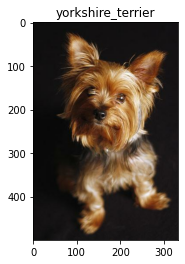

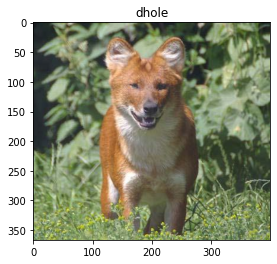

In [ ]:
# This function translates a dog breed label identifier to the breed name.
get_name = info.features['label'].int2str

def get_breed(label_id):
   return get_name(label_id).split('-', 1)[1]

# Display some dog images in the training set and their dog breed
for doggo in dataset['train'].take(2):
    plt.figure()
    plt.imshow(doggo['image'])
    plt.title(get_breed(doggo['label']))

In [ ]:
# Reduce the number of breeds to 20 instead of 120. 

# Since all breeds have the same occurence in the dataset, we choose breeds 0..20.
chosen_breeds = range(20)

def filter_breeds(x, allowed_labels=tf.constant(chosen_breeds)):
    label = x['label']
    isallowed = tf.equal(allowed_labels, tf.cast(label, allowed_labels.dtype))
    reduced = tf.reduce_sum(tf.cast(isallowed, tf.float32))
    return tf.greater(reduced, tf.constant(0.))

def filter_dataset(x):
  return x.filter(filter_breeds)

dataset['train'] = filter_dataset(dataset['train'])
dataset['test'] = filter_dataset(dataset['test'])

In [ ]:
# Turn dataset into dataframe to get some statistics
df_train = tfds.as_dataframe(dataset['train'], info) 
df_test = tfds.as_dataframe(dataset['test'], info) 

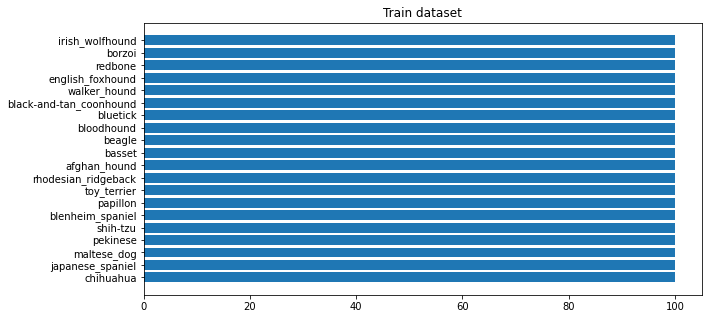

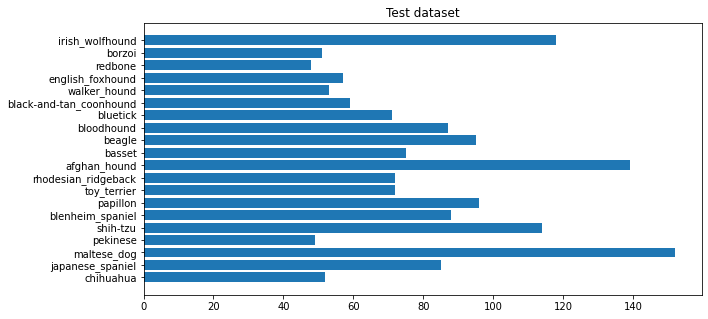

In [ ]:
def print_summary(df, title):

  list_breeds = pd.DataFrame(df['label'].value_counts().sort_index()).reset_index()
  list_breeds.columns = ['breed_id','counts']
  list_breeds['breed_name'] = list_breeds['breed_id'].apply(get_breed)
  list_breeds.style.set_caption(title)
  #print(list_breeds)

  fig = plt.figure(figsize=(10, 5))
  plt.barh(list_breeds['breed_name'], list_breeds['counts'], height=0.8)
  plt.title(title)
  plt.show()


print_summary(df_train, "Train dataset")
print_summary(df_test, "Test dataset")

## Image Preprocessing

In [ ]:
IMG_LEN = 224
IMG_SHAPE = (IMG_LEN,IMG_LEN,3)
#N_BREEDS = 120
N_BREEDS = 20

training_data = dataset['train']
test_data     = dataset['test']

def preprocess(dataset_row):

    # Image conversion from int to float32
    #image = tf.image.convert_image_dtype(dataset_row['image'], dtype=tf.float32)

    # Image resizing to IMG_LEN x IMG_LEN
    image = tf.image.resize(dataset_row['image'], (IMG_LEN, IMG_LEN), method='nearest')
  
    # Onehot encoding labels
    label = tf.one_hot(dataset_row['label'],N_BREEDS)

    #Pre-processing required for vgg16
    image = tf.keras.applications.vgg16.preprocess_input(image)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
   # ds = tf.keras.applications.vgg16.preprocess_input(ds)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

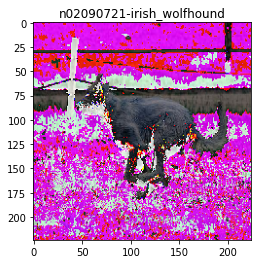

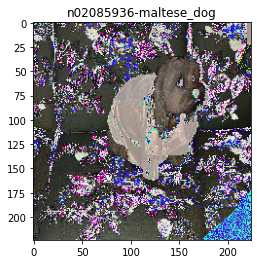

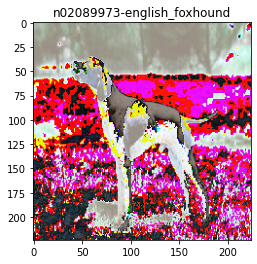

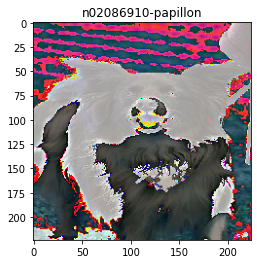

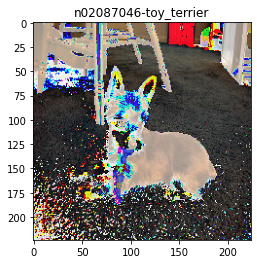

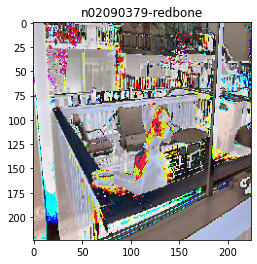

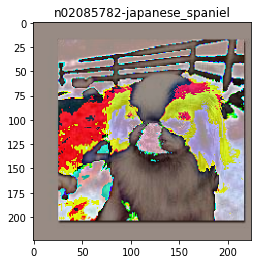

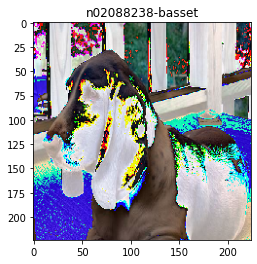

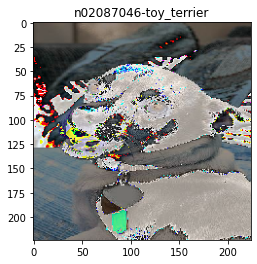

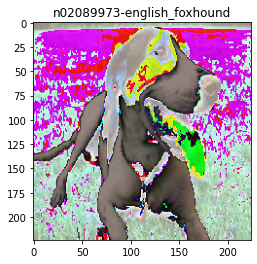

In [ ]:
decode = lambda x: get_name(tf.math.argmax(x))

# Check that preparation is working well
for pic, label in prepare(training_data).take(10):
  plt.figure()
  plt.imshow(pic)
  plt.title(decode(label))


## Training

In [ ]:
# Download VGG16 base model
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

# Freeze all weights in vgg16
base_model.trainable = False

# Layers and model
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),             # transform tensor into vector
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(N_BREEDS, activation='softmax') # dense layer with as many neurons as dog breeds
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 20)                10260     
                                                                 
Total params: 14,987,604
Trainable params: 272,916
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Compile model and fit it

model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
			  
train_batches = prepare(training_data, batch_size=32)
test_batches = prepare(test_data, batch_size=32)

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=test_batches
                    )

Epoch 1/30
63/63 [==============================] - 48s 488ms/step - loss: 8.5324 - accuracy: 0.0435 - top_k_categorical_accuracy: 0.2590 - val_loss: 7.6039 - val_accuracy: 0.0643 - val_top_k_categorical_accuracy: 0.2878
Epoch 2/30
63/63 [==============================] - 38s 484ms/step - loss: 6.5971 - accuracy: 0.0780 - top_k_categorical_accuracy: 0.3500 - val_loss: 6.5694 - val_accuracy: 0.0863 - val_top_k_categorical_accuracy: 0.3503
Epoch 3/30
63/63 [==============================] - 36s 454ms/step - loss: 5.6579 - accuracy: 0.1125 - top_k_categorical_accuracy: 0.4070 - val_loss: 5.9145 - val_accuracy: 0.1102 - val_top_k_categorical_accuracy: 0.3907
Epoch 4/30
63/63 [==============================] - 36s 462ms/step - loss: 5.0092 - accuracy: 0.1385 - top_k_categorical_accuracy: 0.4565 - val_loss: 5.4685 - val_accuracy: 0.1366 - val_top_k_categorical_accuracy: 0.4231
Epoch 5/30
63/63 [==============================] - 36s 459ms/step - loss: 4.5177 - accuracy: 0.1695 - top_k_categor

## Performance


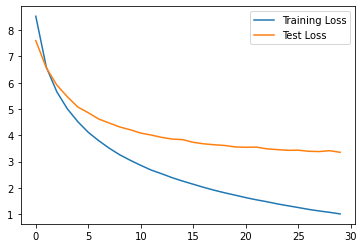

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 